<a href="https://colab.research.google.com/github/sunshine659/Diabetic-Retinopathy-detection-using-ML/blob/master/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from tqdm import tqdm,tqdm_notebook
from prettytable import PrettyTable
import pickle
import os
print('CWD is ',os.getcwd())


from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["axes.grid"] = False


from PIL import Image
import cv2

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau





CWD is  /content


In [ ]:
base_path = "/content/drive/MyDrive/aptos data"

def load_data():
    train = pd.read_csv('train.csv')
    test = pd.read_csv('test.csv')

    train_dir = os.path.join('./','train_images/')
    test_dir = os.path.join('./','test_images/')

    train['file_path'] = train['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
    test['file_path'] = test['id_code'].map(lambda x: os.path.join(test_dir,'{}.png'.format(x)))

    train['file_name'] = train["id_code"].apply(lambda x: x + ".png")
    test['file_name'] = test["id_code"].apply(lambda x: x + ".png")

    train['diagnosis'] = train['diagnosis'].astype(str)

    return train,test

In [ ]:
import os
import pandas as pd

base_path = "/content/drive/MyDrive/aptos data"
df_train = pd.read_csv(os.path.join(base_path, "train.csv"))
df_test = pd.read_csv(os.path.join(base_path, "test.csv"))

print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)
df_train.head()


Train shape: (3662, 2)
Test shape: (1928, 1)


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [ ]:
def plot_classes(df):
    df_group = pd.DataFrame(df.groupby('diagnosis').agg('size').reset_index())
    df_group.columns = ['diagnosis','count']

    sns.set(rc={'figure.figsize':(10,5)}, style = 'whitegrid')
    sns.barplot(x = 'diagnosis',y='count',data = df_group,palette = "Blues_d")
    plt.title('Output Class Distribution')
    plt.show()

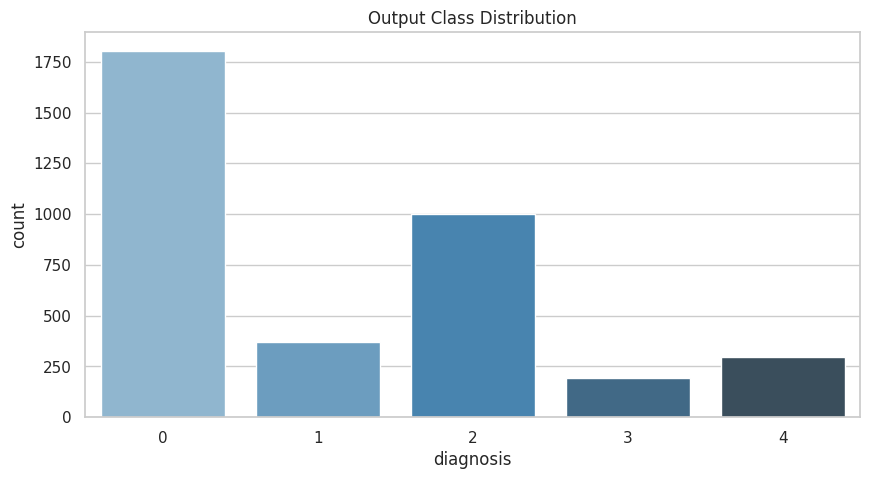

In [ ]:
plot_classes(df_train)

In [ ]:
IMG_SIZE = 200

In [ ]:
def conv_gray(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    return img

def visualize_imgs(df,pts_per_class,color_scale):
    df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(pts_per_class))
    df = df.reset_index(drop = True)

    plt.rcParams["axes.grid"] = False
    for pt in range(pts_per_class):
        f, axarr = plt.subplots(1,5,figsize = (15,15))
        axarr[0].set_ylabel("Sample Data Points")

        df_temp = df[df.index.isin([pt + (pts_per_class*0),pt + (pts_per_class*1), pt + (pts_per_class*2),pt + (pts_per_class*3),pt + (pts_per_class*4)])]
        for i in range(5):
            if color_scale == 'gray':
                img = conv_gray(cv2.imread(df_temp.file_path.iloc[i]))
                axarr[i].imshow(img,cmap = color_scale)
            else:
                axarr[i].imshow(Image.open(df_temp.file_path.iloc[i]).resize((IMG_SIZE,IMG_SIZE)))
            axarr[i].set_xlabel('Class '+str(df_temp.diagnosis.iloc[i]))

        plt.show()

In [ ]:


img_dir = "/content/drive/MyDrive/aptos data/train_images"
csv_path = "/content/drive/MyDrive/aptos data/train.csv"

df_train = pd.read_csv(csv_path)

def visualize_imgs(df, n=9):
    available_imgs = []
    missing_imgs = []

    for i, row in df.iterrows():
        img_path = os.path.join(img_dir, row['id_code'] + ".png")
        if os.path.exists(img_path):
            available_imgs.append((img_path, row['diagnosis']))
        else:
            missing_imgs.append(row['id_code'])

    plt.figure(figsize=(10, 10))
    for i, (path, label) in enumerate(random.sample(available_imgs, min(n, len(available_imgs)))):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis("off")
    plt.show()


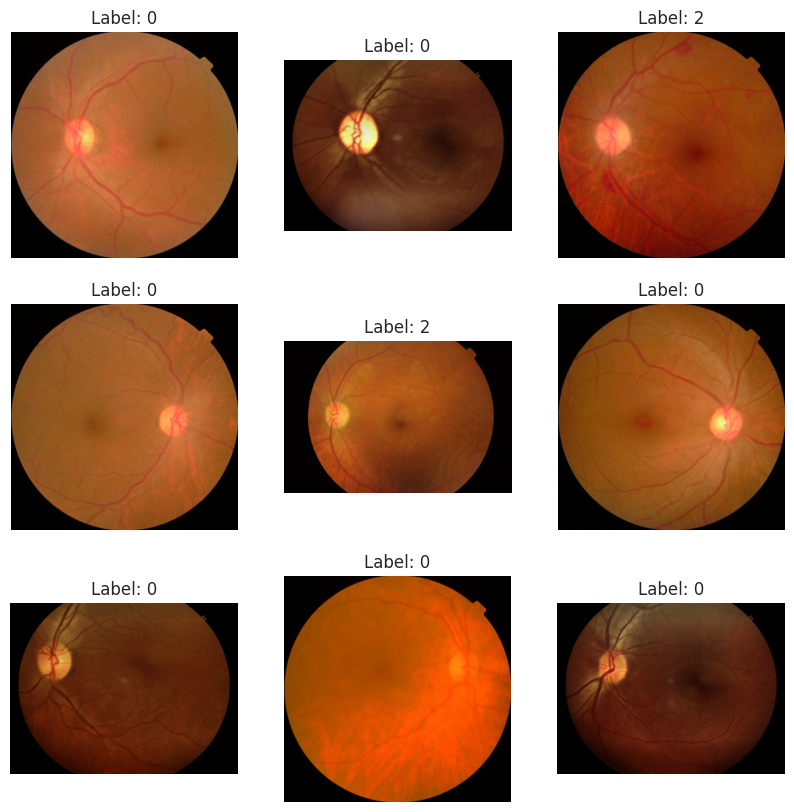

In [ ]:
visualize_imgs(df_train, n=9)


In [ ]:

img_dir = "/content/drive/MyDrive/aptos data/train_images"

def visualize_imgs(df, n=9, color_scale=None):
    paths = [
        (os.path.join(img_dir, row['id_code'] + ".png"), row['diagnosis'])
        for _, row in df.iterrows()
        if os.path.exists(os.path.join(img_dir, row['id_code'] + ".png"))
    ]

    plt.figure(figsize=(10, 10))
    for i, (path, label) in enumerate(random.sample(paths, min(n, len(paths)))):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY if color_scale == 'gray' else cv2.COLOR_BGR2RGB)
        plt.subplot(3, 3, i + 1)
        plt.imshow(img, cmap='gray' if color_scale == 'gray' else None)
        plt.title(f"Label: {label}")
        plt.axis("off")
    plt.show()


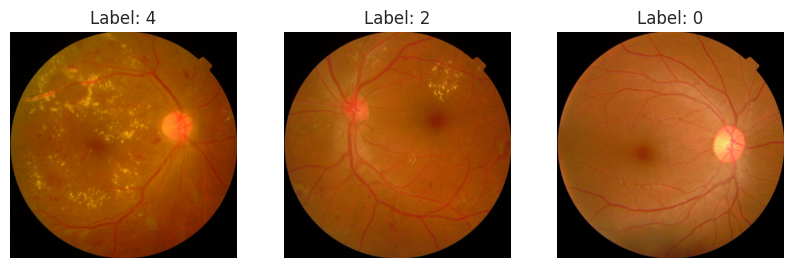

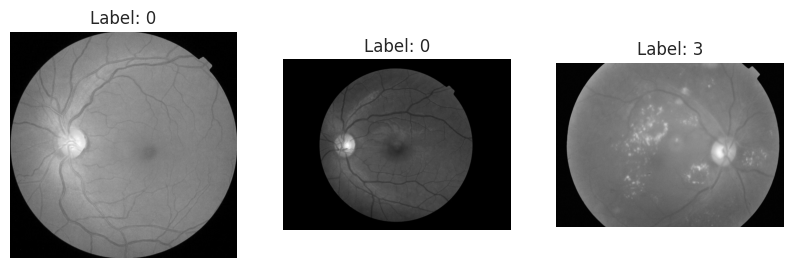

In [ ]:
visualize_imgs(df_train, 3)
visualize_imgs(df_train, 3, 'gray')


In [ ]:

df_train["file_path"] = df_train["id_code"].apply(lambda x: os.path.join(img_dir, x + ".png"))

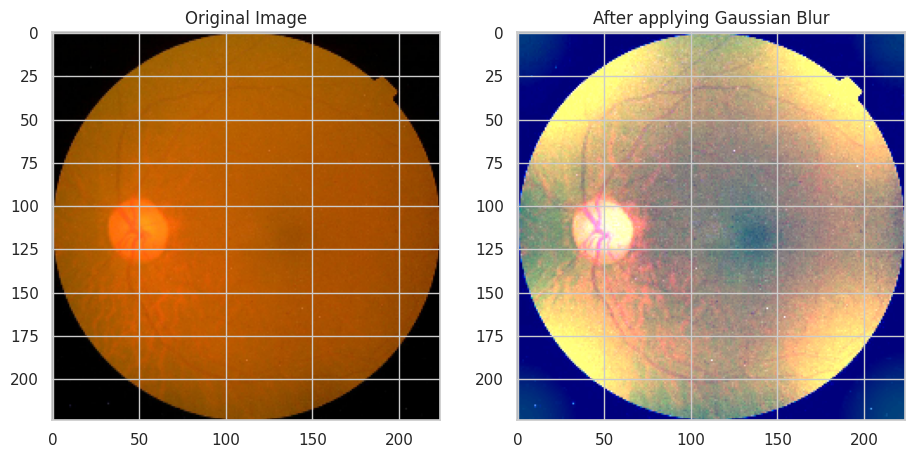

In [ ]:
IMG_SIZE = 224

while True:
    rn = np.random.randint(low=0, high=len(df_train) - 1)
    img_path = df_train.file_path.iloc[rn]

    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        if img is not None:
            break  # found a valid image



img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))


img_t = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0), 30), -4, 128)


f, axarr = plt.subplots(1, 2, figsize=(11, 11))
axarr[0].imshow(img)
axarr[1].imshow(img_t)
axarr[0].set_title("Original Image")
axarr[1].set_title("After applying Gaussian Blur")
plt.show()

In [ ]:
def generate_augmentations(lim):
    datagen = ImageDataGenerator(featurewise_center=True,
                                 featurewise_std_normalization=True,
                                 rotation_range=20,
                                 #width_shift_range=0.2,
                                 #height_shift_range=0.2,
                                 horizontal_flip=True)
    img = cv2.imread(df_train.file_path.iloc[np.random.randint(low = 0,high = len(df_train) - 1)])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.title('ORIGINAL IMAGE')
    plt.show()

    img_arr = img.reshape((1,) + img.shape)

    i = 0
    for img_iterator in datagen.flow(x = img_arr,batch_size = 1):
        i = i + 1
        if i > lim:
            break
        plt.imshow((img_iterator.reshape(img_arr[0].shape)).astype(np.uint8))
        plt.title('IMAGE AUGMENTATION ' + str(i))
        plt.show()

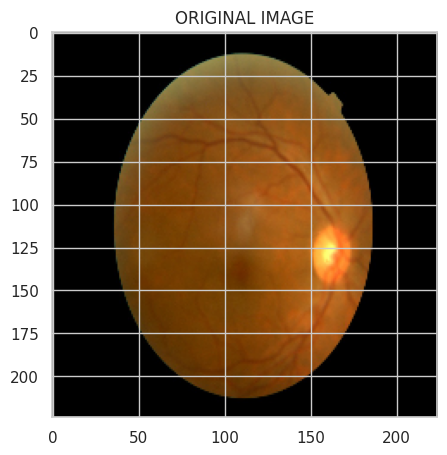

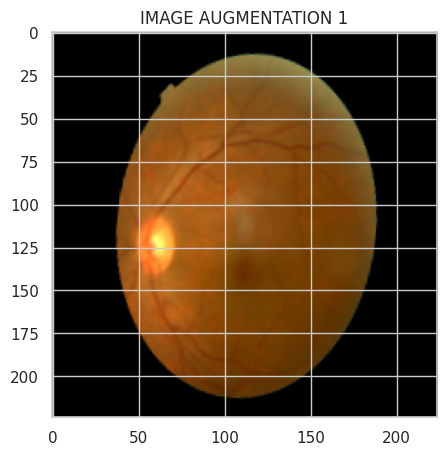

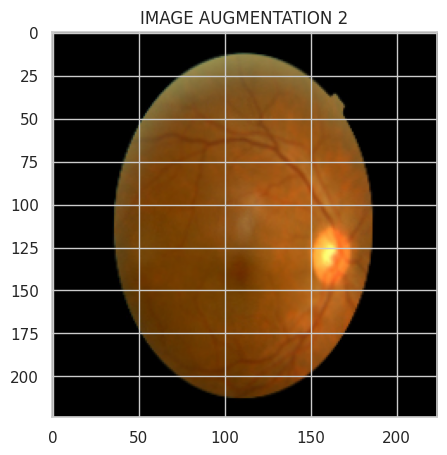

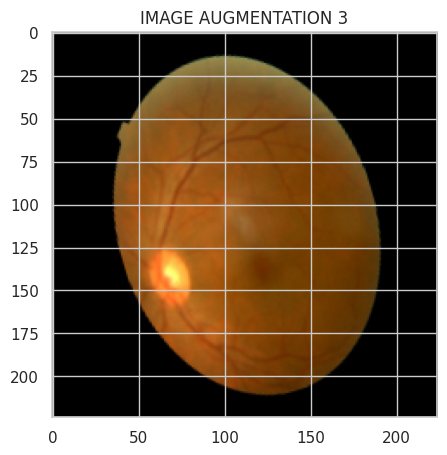

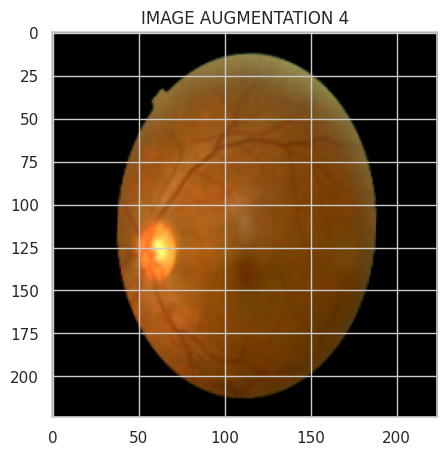

In [ ]:
generate_augmentations(4)

In [ ]:
import pandas as pd
import numpy as np
import os
from prettytable import PrettyTable
import pickle
import multiprocessing
from multiprocessing.pool import ThreadPool
print(multiprocessing.cpu_count()," CPU cores")

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False

from sklearn.metrics import confusion_matrix, cohen_kappa_score,accuracy_score

from PIL import Image
import cv2

2  CPU cores


In [ ]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 987.4/987.4 kB 15.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
BASE       = '/content/drive/MyDrive/aptos data'
TRAIN_DIR  = f'{BASE}/train_images'
TEST_DIR   = f'{BASE}/test_images'
TRAIN_CSV  = f'{BASE}/train.csv'
TEST_CSV   = f'{BASE}/test.csv'

print('Train imgs :', len(os.listdir(TRAIN_DIR)))
print('Test  imgs :', len(os.listdir(TEST_DIR)))

Train imgs : 1356
Test  imgs : 1928


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv(TRAIN_CSV)
df["file_path"] = df["id_code"].apply(lambda x: os.path.join(TRAIN_DIR, x + ".png"))
df["exists"] = df["file_path"].apply(os.path.exists)



In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 10
LR = 1e-4

In [ ]:
df_train = pd.read_csv(TRAIN_CSV)
df_test = pd.read_csv(TEST_CSV)

In [ ]:
df_train["file_path"] = df_train["id_code"].apply(lambda x: os.path.join(TRAIN_DIR, x + ".png"))
df_test["file_path"] = df_test["id_code"].apply(lambda x: os.path.join(TEST_DIR, x + ".png"))

In [ ]:
df_train = df_train[df_train["file_path"].apply(os.path.exists)].reset_index(drop=True)
df_test = df_test[df_test["file_path"].apply(os.path.exists)].reset_index(drop=True)


In [ ]:
print(f"✅ Train images available: {len(df_train)}")
print(f"✅ Test images available : {len(df_test)}")

✅ Train images available: 1356
✅ Test images available : 1928


In [ ]:
IMG_SIZE = 224

def load_images(df, is_test=False):
    imgs = []
    labels = []
    for i, row in tqdm(df.iterrows(), total=len(df)):
        img = cv2.imread(row["file_path"])
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            imgs.append(img)
            if not is_test:
                labels.append(row["diagnosis"])
    if is_test:
        return np.array(imgs)
    else:
        return np.array(imgs), np.array(labels)

X, y = load_images(df_train, is_test=False)
X_test = load_images(df_test, is_test=True)

X = X / 255.0
X_test = X_test / 255.0

100%|██████████| 1928/1928 [10:10<00:00,  3.16it/s]


In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
from tensorflow.keras.applications import ResNet50


In [ ]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in base_model.layers:
    layer.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [ ]:
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
out = Dense(5, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=out)
model.compile(optimizer=Adam(1e-4), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,597,957 (90.02 MB)

 Trainable params: 10,245 (40.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)


In [ ]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    validation_data=(X_val, y_val),
    epochs=10,
    verbose=1
)

Epoch 1/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 181s 3s/step - accuracy: 0.0520 - loss: 2.8626 - val_accuracy: 0.0441 - val_loss: 1.4085
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.4197 - loss: 1.3081 - val_accuracy: 0.7978 - val_loss: 0.8466
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.7602 - loss: 0.9304 - val_accuracy: 0.7978 - val_loss: 0.7655
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.7825 - loss: 0.8608 - val_accuracy: 0.7978 - val_loss: 0.7476
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 171s 3s/step - accuracy: 0.8111 - loss: 0.7759 - val_accuracy: 0.7978 - val_loss: 0.7427
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 193s 3s/step - accuracy: 0.7835 - loss: 0.8142 - val_accuracy: 0.7978 - val_loss: 0.7408
Epoch 7/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.7710 - loss: 0.8802 - val_accuracy: 0.7978 - val_loss: 0.7411
Epoch 8/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.7944 - loss: 0.7865 - val_accuracy: 0.7978 - v

In [ ]:
loss, acc = model.evaluate(X_val, y_val)
print(f"✅ Validation Accuracy: {acc * 100:.2f}%")

9/9 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.8143 - loss: 0.7048
✅ Validation Accuracy: 79.78%


In [ ]:
preds = model.predict(X_test)
pred_labels = np.argmax(preds, axis=1)

61/61 ━━━━━━━━━━━━━━━━━━━━ 220s 4s/step


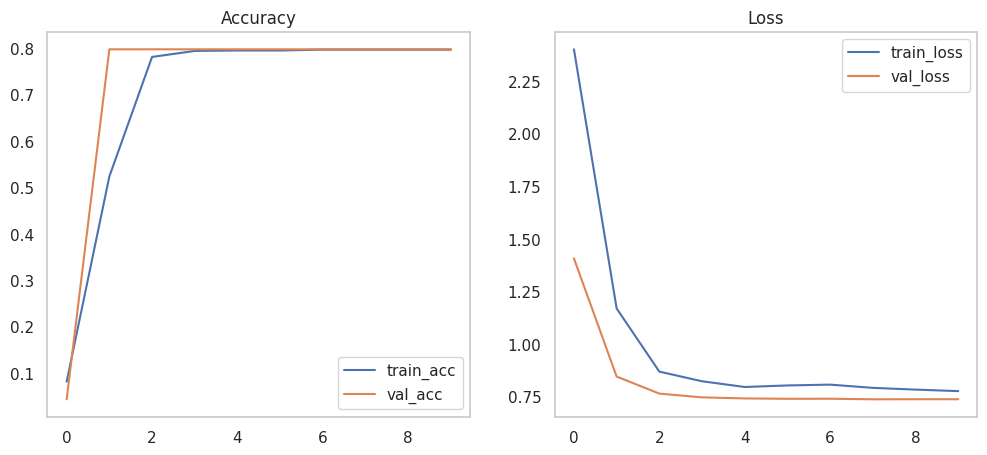

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss")
plt.show()